In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statannotations.Annotator import Annotator
import sys
sys.path.append('/home/local/VANDERBILT/litz/github/MASILab/lobe_seg')
from luna16_preprocess import get_kfolds

In [17]:
metric_dir = "/home/local/VANDERBILT/litz/data/luna16/metrics"
johof_folds = glob.glob(os.path.join(metric_dir, "johof_norm*"))
lsm_folds = glob.glob(os.path.join(metric_dir, "lsm_*"))
model_dir = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/models/0511cval"
kfolds_path = "/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/5folds.csv"
# kfolds_path = "/home/local/VANDERBILT/litz/data/luna16/5fold_qa.csv"
fold_paths = get_kfolds(kfolds_path)

unet3d_folds = []
for d, _, _ in os.walk(model_dir):
    unet3d_folds.extend(glob.glob(os.path.join(d, "dataset_rand*.csv")))

johof_folds = sorted(johof_folds)
lsm_folds = sorted(lsm_folds)
unet3d_folds = sorted(unet3d_folds)


'1'

In [19]:
# parse metric csv's into dataframes
unet_df = pd.read_csv(unet3d_folds[0])
unet_df["fold"] = int(unet3d_folds[0][-23])
for i, unet3d_fold in enumerate(unet3d_folds):
    if i > 0:
        unet_fold_df = pd.read_csv(unet3d_fold)
        unet_fold_df["fold"] = int(unet3d_fold[-23])
        unet_df = pd.concat([unet_df, unet_fold_df], ignore_index=True)
unet_df.drop(columns=['Unnamed: 0'], inplace=True)
unet_df['id'] = unet_df.index
unet_df

,0,1,2,3,4,input_path,fold,id
0,0.973187,0.973336,0.942895,0.784275,0.925650,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,0
1,0.980912,0.975926,0.956717,0.907810,0.966566,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,1
2,0.965828,0.977428,0.963507,0.923020,0.976666,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,2
3,0.938645,0.941528,0.939121,0.828809,0.960739,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,3
4,0.978514,0.973776,0.965877,0.905593,0.938307,/home/local/VANDERBILT/litz/data/imagevu/nifti...,1,4
...,...,...,...,...,...,...,...,...
72,0.972982,0.969204,0.961220,0.937658,0.972373,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,72
73,0.916146,0.894923,0.965009,0.944907,0.953961,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,73
74,0.978931,0.977038,0.925101,0.930052,0.955465,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,74
75,0.953747,0.913110,0.951838,0.870724,0.944766,/home/local/VANDERBILT/litz/data/imagevu/nifti...,5,75


In [20]:
pd.set_option('display.max_colwidth', None)
edge_cases = unet_df[unet_df["3"]<=0.7]
edge_cases

,0,1,2,3,4,input_path,fold,id
7,0.983587,0.975007,0.854607,0.626814,0.938171,/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.416701701108520592702405866796.nii.gz,1,7
17,0.970210,0.970195,0.789945,0.054860,0.844902,/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.nii.gz,2,17
28,0.979243,0.978380,0.940047,0.532289,0.915335,/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00001033time20181022.nii.gz,2,28
35,0.981468,0.985243,0.922692,0.607652,0.961703,/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.119304665257760307862874140576.nii.gz,3,35
40,0.968017,0.962320,0.873146,0.526891,0.969967,/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/00000541time20180628.nii.gz,3,40
60,0.963097,0.966511,0.511296,0.216661,0.947030,/home/local/VANDERBILT/litz/data/imagevu/nifti/active_learning/dataset_rand/train/1.3.6.1.4.1.14519.5.2.1.6279.6001.151669338315069779994664893123.nii.gz,5,60


In [16]:
# function that maps an input int (as str type) to name of lobe
def lobe_map(x):
    if x=='0': return 'LUL'
    if x=='1': return 'LLL'
    if x=='2': return 'RUL'
    if x=='3': return 'RML'
    if x=='4': return 'RLL'
unet_long = pd.melt(unet_df, id_vars=['id', 'fold'], value_vars=['0', '1', '2', '3', '4'])
unet_long['model'] = '3DUnet'
unet_long = unet_long.rename(columns={'variable':'Lobe', 'value': 'Dice score'})
unet_long['Lobe'] = unet_long['Lobe'].apply(lobe_map)
unet_long

,id,fold,Lobe,Dice score,model
0,0,1,LUL,0.973187,3DUnet
1,1,1,LUL,0.980912,3DUnet
2,2,1,LUL,0.965828,3DUnet
3,3,1,LUL,0.938645,3DUnet
4,4,1,LUL,0.978514,3DUnet
...,...,...,...,...,...
230,42,5,RLL,0.975286,3DUnet
231,43,5,RLL,0.948071,3DUnet
232,44,5,RLL,0.976631,3DUnet
233,45,5,RLL,0.980709,3DUnet


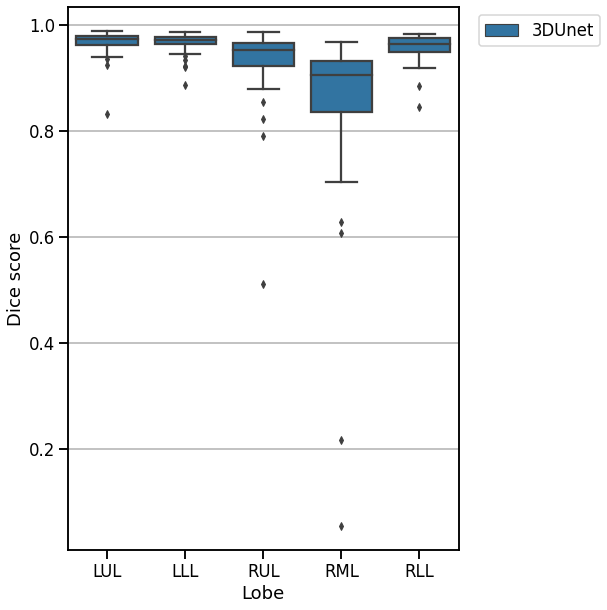

In [17]:
all_df = unet_long
sns.set_context(context="talk")
f, ax = plt.subplots(figsize=(7,10))
sns.boxplot(x="Lobe", y="Dice score", hue="model", data=all_df)
ax.yaxis.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

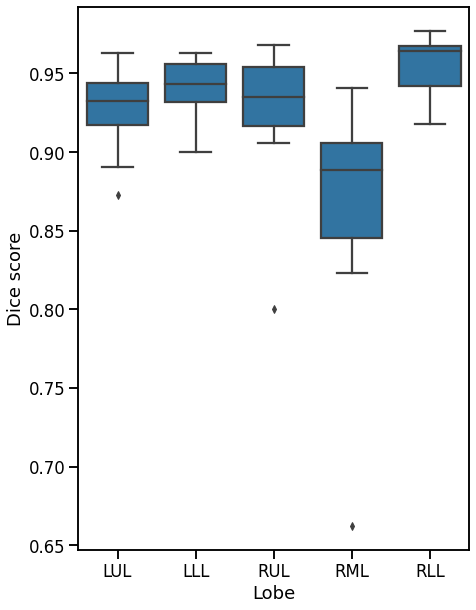

In [18]:
f, ax = plt.subplots(figsize=(7, 10))
b = sns.boxplot(x="Lobe", y="Dice score", data=all_df[all_df["fold"]==4], hue="model", orient="v")
ax.get_legend().remove()